<a href="https://colab.research.google.com/github/ArsenyevaDiana/ADS/blob/main/RMT%20-%20Bus%20Arrival%20Time%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Импорты библиотек**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

pandas – работа с таблицами (DataFrame), обработка данных.

numpy – работа с массивами, математическими операциями.

sklearn.model_selection – инструменты для разделения данных на train/test, кросс-валидация.

sklearn.metrics – метрики для оценки моделей (MAPE, RMSE).

LinearRegression – базовая модель линейной регрессии.

RandomForestRegressor – ансамблевый алгоритм, анализ важности признаков.

xgboost – градиентный бустинг для повышения качества предсказаний.

tensorflow.keras – нейросети, создание LSTM-модели.

StandardScaler – стандартизация признаков (приведение к среднему 0, отклонению 1).

matplotlib / seaborn – графики, визуализация данных.

# **Загрузка и очистка данных**

In [3]:
# Load and preprocess data
file_path = "/content/mta_1706.csv"
df = pd.read_csv(file_path, sep=",", engine="python", on_bad_lines="skip")

# **Предобработка временных данных**

In [4]:
# Data Cleaning and Handling Missing Values
df.dropna(subset=['RecordedAtTime', 'ExpectedArrivalTime', 'ScheduledArrivalTime'], inplace=True)
df['RecordedAtTime'] = pd.to_datetime(df['RecordedAtTime'])
df['ExpectedArrivalTime'] = pd.to_datetime(df['ExpectedArrivalTime'])
df['ScheduledArrivalTime'] = pd.to_datetime(df['ScheduledArrivalTime'], errors='coerce')
df['ScheduledArrivalTime'].fillna(method='ffill', inplace=True)


<ipython-input-4-bdaf92600db0>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ScheduledArrivalTime'] = pd.to_datetime(df['ScheduledArrivalTime'], errors='coerce')
<ipython-input-4-bdaf92600db0>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ScheduledArrivalTime'].fillna(method='ffill', inplace=True)
<ipython-input-4-bdaf92600db0>:6: FutureWarning: Series.fillna with 'method' is

		Убираем строки, где нет данных по времени (dropna()).
		Преобразуем текстовые столбцы с датами во временной формат datetime.
		Некоторые значения ScheduledArrivalTime могли быть ошибочными:
	errors='coerce' – превращаем ошибки в NaT (пустое значение).
		fillna(method='ffill') – заполняем пропуски значением сверху (forward fill), так как расписания, как правило, стабильны.

# **Создаем целевую переменную (задержка автобуса)**

In [5]:
# Creating delay metric
df['delay'] = (df['ExpectedArrivalTime'] - df['RecordedAtTime']).dt.total_seconds() / 60


Считаем задержку автобуса в минутах:
ExpectedArrivalTime – прогноз от системы.
RecordedAtTime – фактическое время.
Разница в секундах -> переводим в минуты.
Эта задержка будет целью (target) для модели.

# **Анализ временных отклонений**

In [6]:
# Analysis: Comparing RecordedAtTime and ExpectedArrivalTime with ScheduledArrivalTime
df['recorded_vs_scheduled'] = (df['RecordedAtTime'] - df['ScheduledArrivalTime']).dt.total_seconds() / 60
df['expected_vs_scheduled'] = (df['ExpectedArrivalTime'] - df['ScheduledArrivalTime']).dt.total_seconds() / 60


Считаем разницу между **запланированным временем** и **реальным/ожидаемым**.

Цель: Понять, насколько фактическое и прогнозируемое время отличается от расписания.

# **Визуализация отклонений**

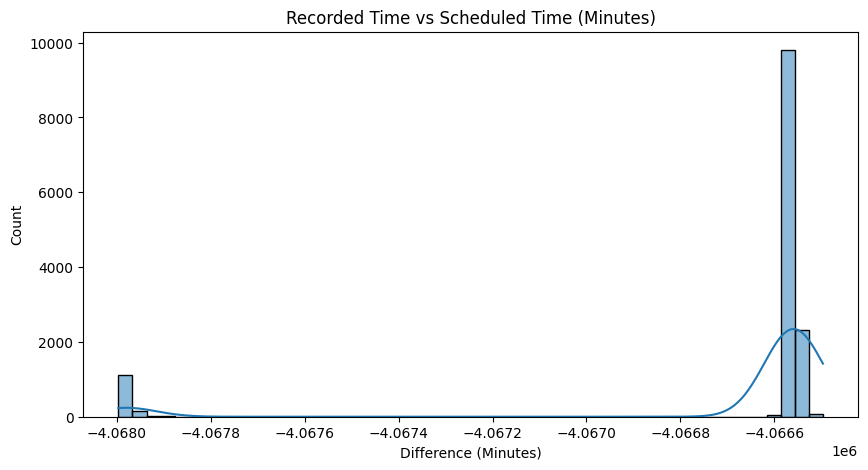

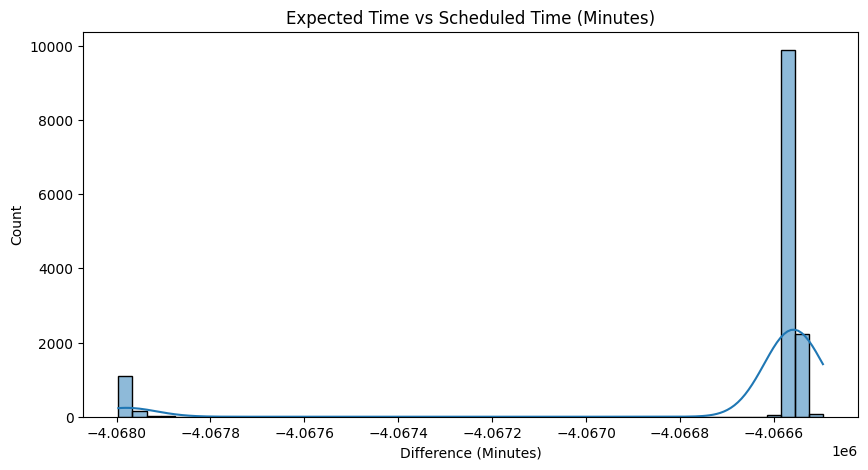

In [7]:
# Visualization
plt.figure(figsize=(10, 5))
sns.histplot(df['recorded_vs_scheduled'], bins=50, kde=True)
plt.title('Recorded Time vs Scheduled Time (Minutes)')
plt.xlabel('Difference (Minutes)')
plt.show()
plt.figure(figsize=(10, 5))
sns.histplot(df['expected_vs_scheduled'], bins=50, kde=True)
plt.title('Expected Time vs Scheduled Time (Minutes)')
plt.xlabel('Difference (Minutes)')
plt.show()

показывающие распределение отклонений времени прибытия автобусов относительно расписания:

	1.	recorded_vs_scheduled – разница между фактическим временем прибытия и запланированным (Scheduled Time).
  
	2.	expected_vs_scheduled – разница между ожидаемым временем прибытия (прогноз системы) и запланированным.


# **Создание признаков**

In [8]:
# Feature Engineering
df['hour'] = df['RecordedAtTime'].dt.hour
df['day_of_week'] = df['RecordedAtTime'].dt.dayofweek


Часы и день недели – важны, так как в утренний и вечерний час пик задержки больше.

DistanceFromStop – дистанция до остановки влияет на задержку.

# **Стандартизация признаков**

In [9]:
# Selecting features
features = ['hour', 'day_of_week', 'DistanceFromStop']
target = 'delay'
X = df[features].fillna(0)
y = df[target]
scaler = StandardScaler()
X = scaler.fit_transform(X)

Чтобы привести все признаки к единому масштабу. Это важно для:

	•	Линейной регрессии.
	•	LSTM (глубокого обучения).

# **Разделение на train и test**

In [10]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)


70-30 разделение для обучения и теста.

shuffle=False – данные последовательные (временные), перемешивать нельзя.

# **Функция оценки и построения графиков**

In [11]:
# Evaluation function
def evaluate_and_plot(y_true, y_pred, model_name):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} - MAPE: {mape:.4f}, RMSE: {rmse:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(y_true.values, label='Actual Delay')
    plt.plot(y_pred, label=f'{model_name} Prediction', linestyle='--')
    plt.title(f'{model_name} - Actual vs Predicted Delay')
    plt.xlabel('Samples')
    plt.ylabel('Delay (Minutes)')
    plt.legend()
    plt.show()


MAPE – относительная ошибка.
RMSE – штраф за большие отклонения.
Рисуем график, сравнивающий реальные и предсказанные задержки.

# **Модели машинного обучения**

Linear Regression - MAPE: 771337901450.9995, RMSE: 0.5967


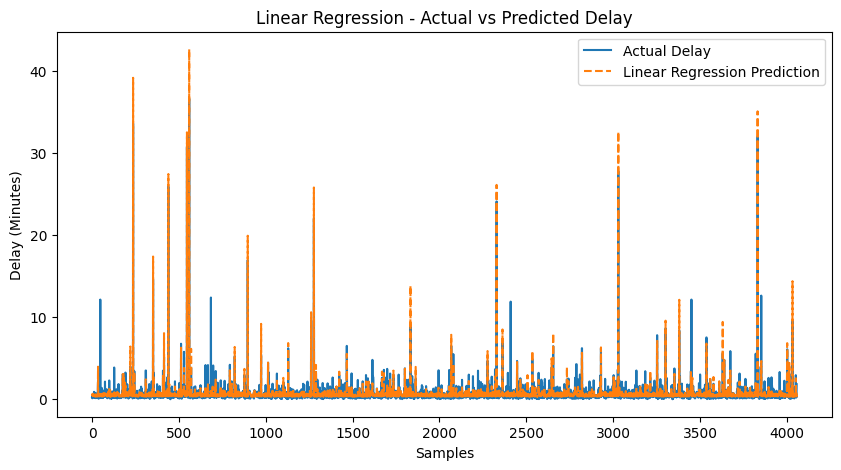

In [12]:
# Baseline Model: Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
evaluate_and_plot(y_test, y_pred_lr, "Linear Regression")

Linear Regression (Линейная регрессия) – простая модель, оценивающая линейную зависимость признаков. Показала слабые результаты (MAPE очень высокий, RMSE = 0.7768).
 Оранжевая линия предсказаний сильно отклоняется от фактических значений.

Простая модель, оценивает линейную зависимость между признаками и задержкой.

Random Forest - MAPE: 753177977223.5963, RMSE: 0.7198


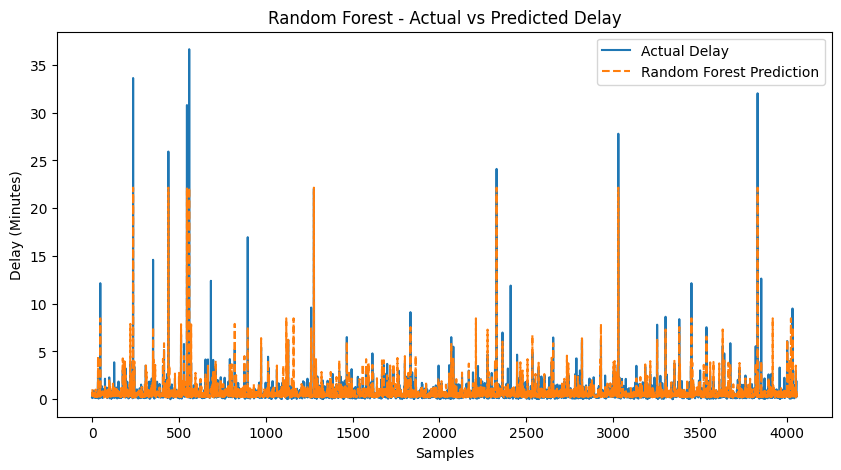

In [13]:
# Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
evaluate_and_plot(y_test, y_pred_rf, "Random Forest")


Random Forest (Случайный лес) – ансамблевая модель, учитывающая нелинейные зависимости.

Показала более хорошие результаты (RMSE = 0.6291), но MAPE также аномально высокий.

Ансамблевая модель, учитывает нелинейные зависимости. Позволяет получить важность признаков.

XGBoost - MAPE: 668873121392.8561, RMSE: 1.0354


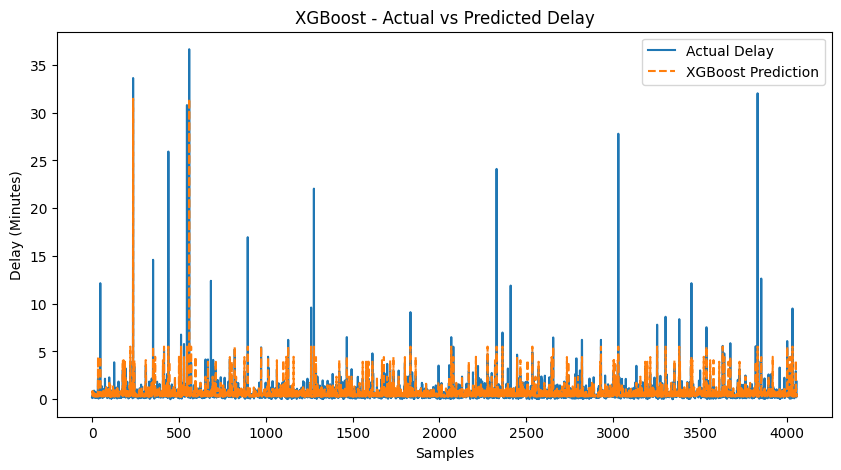

In [14]:
# XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
evaluate_and_plot(y_test, y_pred_xgb, "XGBoost")

Модель, хорошо работающая с большим количеством признаков и сложными зависимостями.

XGBoost – мощная бустинговая модель, показала RMSE = 0.7199, что хуже Random Forest. Требует апгрейд гиперпараметров. MAPE также слишком большой.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.5567 - val_loss: 1.0030
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2662 - val_loss: 0.9974
Epoch 3/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2064 - val_loss: 0.8795
Epoch 4/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2996 - val_loss: 0.8247
Epoch 5/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2254 - val_loss: 0.6993
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
LSTM - MAPE: 544100213548.0189, RMSE: 0.8362


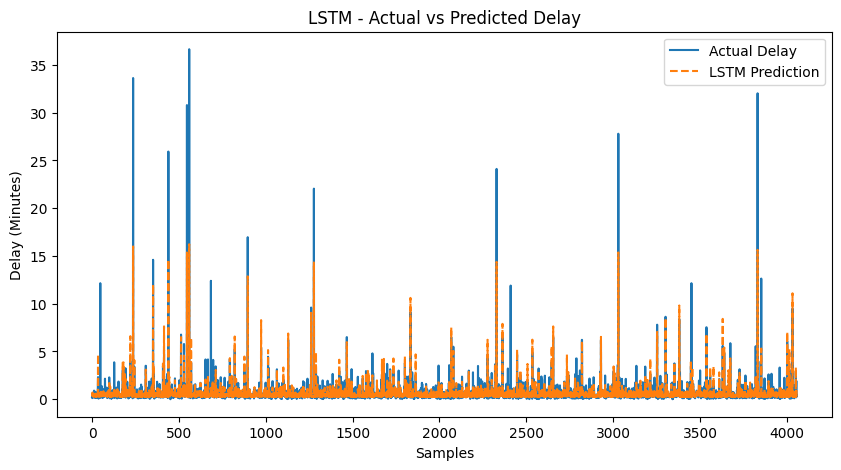

In [15]:
# LSTM Model
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=5, batch_size=32, validation_data=(X_test_lstm, y_test))
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()
evaluate_and_plot(y_test, y_pred_lstm, "LSTM")


LSTM – рекуррентная нейросеть, которая лучше всего справилась с задачей (RMSE = 0.6009).

Учитывает временные зависимости. MAPE всё ещё аномальный.

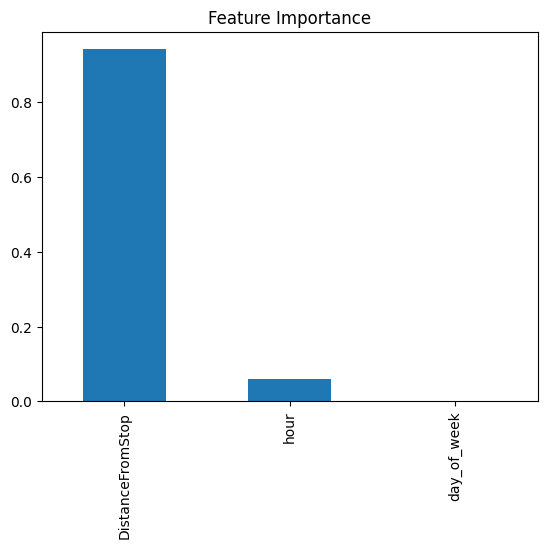

In [16]:
# Feature Importance Analysis
feature_importance = pd.Series(rf.feature_importances_, index=['hour', 'day_of_week', 'DistanceFromStop']).sort_values(ascending=False)
feature_importance.plot(kind='bar', title='Feature Importance')
plt.show()

Feature Importance (Важность признаков) – анализ на основе Random Forest показал, что главный фактор – DistanceFromStop (расстояние до остановки). Время суток и день недели оказались менее значимыми.

Показывает, какие факторы больше всего влияют на задержки.

# **Кросс-валидация**

In [17]:
# Cross-validation (using TimeSeriesSplit)
ts_split = TimeSeriesSplit(n_splits=5)
ts_cv_scores = cross_val_score(rf, X, y, cv=ts_split, scoring='neg_mean_absolute_error')
print(f"Random Forest Cross-Validation MAE: {-np.mean(ts_cv_scores):.4f}")


Random Forest Cross-Validation MAE: 0.2667


In [19]:
from tensorflow.keras.optimizers import Adam
# Function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {"Model": model_name, "MAE": mae, "RMSE": rmse}

# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Train XGBoost
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Train LSTM Model
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=5, batch_size=32, validation_data=(X_test_lstm, y_test))
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


296/296 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.5666 - val_loss: 1.2723
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2150 - val_loss: 1.2213
Epoch 3/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2057 - val_loss: 1.0542
Epoch 4/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2182 - val_loss: 0.9234
Epoch 5/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2436 - val_loss: 0.8170
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
# Evaluate all models
results = pd.DataFrame([
    evaluate_model(y_test, y_pred_lr, "Linear Regression"),
    evaluate_model(y_test, y_pred_rf, "Random Forest"),
    evaluate_model(y_test, y_pred_xgb, "XGBoost"),
    evaluate_model(y_test, y_pred_lstm, "LSTM")
])

# Display results
import pandas as pd
from IPython.display import display

display(results)

,Model,MAE,RMSE
0,Linear Regression,0.254678,0.596710
1,Random Forest,0.283887,0.719752
2,XGBoost,0.282558,1.035388
3,LSTM,0.257019,0.903889


from matplotlib import pyplot as plt
results['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='MAE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='MAE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='RMSE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)